In [18]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(r'\2021+historical data (happiness score).csv')
data_2021 = data.iloc [0:148]


# data cleaning
# check na value 
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country name                  2100 non-null   object 
 1   year                          2100 non-null   int64  
 2   Ladder score                  2100 non-null   float64
 3   Logged GDP per capita         2064 non-null   float64
 4   Social support                2087 non-null   float64
 5   Healthy life expectancy       2045 non-null   float64
 6   Freedom to make life choices  2068 non-null   float64
 7   Generosity                    2011 non-null   float64
 8   Perceptions of corruption     1990 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 147.8+ KB


Country name                      0
year                              0
Ladder score                      0
Logged GDP per capita            36
Social support                   13
Healthy life expectancy          55
Freedom to make life choices     32
Generosity                       89
Perceptions of corruption       110
dtype: int64

In [19]:
# fill in the na value by mean
mean = data["Logged GDP per capita"].mean()
data["Logged GDP per capita"].fillna(mean,inplace = True)

mean = data["Social support"].mean()
data["Social support"].fillna(mean,inplace = True)

mean = data["Healthy life expectancy"].mean()
data["Healthy life expectancy"].fillna(mean,inplace = True)

mean = data["Freedom to make life choices"].mean()
data["Freedom to make life choices"].fillna(mean,inplace = True)

mean = data["Generosity"].mean()
data["Generosity"].fillna(mean,inplace = True)

mean = data["Perceptions of corruption"].mean()
data["Perceptions of corruption"].fillna(mean,inplace = True)

data.isnull().sum()

Country name                    0
year                            0
Ladder score                    0
Logged GDP per capita           0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

In [20]:
test_data = data.iloc [0:148] # 2021 data as test 
train_data = data.iloc [149:] # other histroal data as train set

test_data = test_data.iloc[:,2:] # remove country and year in data
train_data = train_data.iloc[:,2:] # remove country and year in data


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_X = train_data[:,1:7]
test_X = test_data[:,1:7]
# X is our input variables

train_Y = train_data[:,0]
test_Y = test_data[:,0]

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV # Create the parameter grid based on the results of random search 

tree_reg = tree.DecisionTreeRegressor(random_state = 3011)

param_distribs = {
    
    'max_depth': range(2,100),
    'min_samples_split': range(2,100),
    "max_leaf_nodes":range(2,100)
}

grid_search =RandomizedSearchCV(estimator = tree_reg, param_distributions = param_distribs, 
                          cv = 3, n_iter=50,scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(train_X,train_Y)
grid_search.best_params_ #Hyperparameter Tuning

{'min_samples_split': 82, 'max_leaf_nodes': 96, 'max_depth': 5}

In [21]:
tree_reg = tree.DecisionTreeRegressor(random_state=3011, max_depth = 5,
max_leaf_nodes = 96,
min_samples_split = 82)

tree_reg.fit(train_X,train_Y)
pred = tree_reg.predict(test_X)

In [8]:
pred = pred.reshape(pred.shape[0],1) # inverse the StandardScaler
pred_copy = np.repeat(pred,7,axis=-1)
pred = scaler.inverse_transform(pred_copy)[:,0]


test_Y = test_Y.reshape(test_Y.shape[0],1) # inverse the StandardScaler
test_Y_copy = np.repeat(test_Y,7,axis=-1)
test_Y = scaler.inverse_transform(test_Y_copy)[:,0]

from sklearn.metrics import mean_squared_error
mean_squared_error(test_Y,pred)

0.23984960094354157

Text(0.5, 1.0, 'Feature import(Decison Tree)')

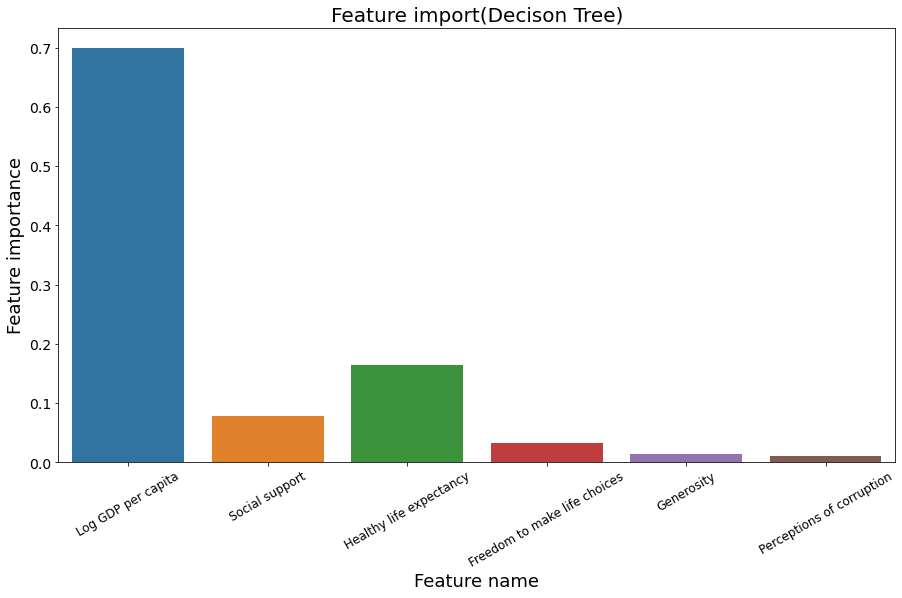

In [22]:
model = tree_reg.fit(train_X,train_Y)
feature_importances_=model.feature_importances_
col_to_consider=['Log GDP per capita', 'Social support',
       'Healthy life expectancy',
       'Freedom to make life choices',
       'Generosity', 'Perceptions of corruption',
       ]
feature_importances=pd.DataFrame({'Feature_name':col_to_consider, 'Feature_importance':feature_importances_})

fig, ax=plt.subplots(1, figsize=(15,8))
sns.barplot(x='Feature_name', y='Feature_importance', data=feature_importances, ax=ax)

# For making the graph look good
plt.xticks(fontsize=12, rotation=30); # Rotating the names by 30 degrees as the names were mixing with each other 
plt.yticks(fontsize=14);

plt.xlabel('Feature name',fontsize=18)
plt.ylabel('Feature importance',fontsize=18)
plt.title("Feature import(Decison Tree)",fontsize=20)

In [11]:
import geopandas as gpd

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


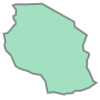

In [13]:
world['geometry'][1]

In [14]:
country_data = list(data_2021['Country name'].unique())
country_geo = list(world['name'])

country_diff = [country for country in country_data if country not in country_geo]
country_diff

['Czech Republic',
 'United States',
 'Bahrain',
 'Malta',
 'Taiwan Province of China',
 'Singapore',
 'Mauritius',
 'Bosnia and Herzegovina',
 'Dominican Republic',
 'North Cyprus',
 'Hong Kong S.A.R. of China',
 'Congo (Brazzaville)',
 'Ivory Coast',
 'Maldives',
 'North Macedonia',
 'Palestinian Territories',
 'Swaziland',
 'Comoros']

In [15]:
data_2021['Country name'] = data_2021['Country name'].replace({'United States' : 'United States of America',
                                          'Taiwan Province of China':'Taiwan',
                                          'Bosnia and Herzegovina':'Bosnia and Herz.',
                                          'Dominican Republic':'Dominican Rep.',
                                          'North Cyprus':'N. Cyprus',
                                          'Swaziland':'Switzerland'})

C:\Users\henry\AppData\Local\Temp/ipykernel_8820/2380443316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2021['Country name'] = data_2021['Country name'].replace({'United States' : 'United States of America',


In [16]:
def plot_on_worldmap(df, col_to_map, title=None):
    # Plotting on world map
    mapped = world.set_index('name').join(df.set_index('Country name')).reset_index() # Joins the df with world data for plotting

    to_be_mapped = col_to_map # The column name which is to shown on map
    vmin, vmax = df[col_to_map].min(), df[col_to_map].max()# Minimum and maximum values for the column

    fig, ax = plt.subplots(1, figsize=(20,10))

    mapped.dropna().plot(column=to_be_mapped, cmap='Blues', linewidth=0.8,legend=True, ax=ax, 
                         edgecolors='0.8', legend_kwds={'shrink': 0.5})

    ax.set_title(title, fontdict={'fontsize':20})

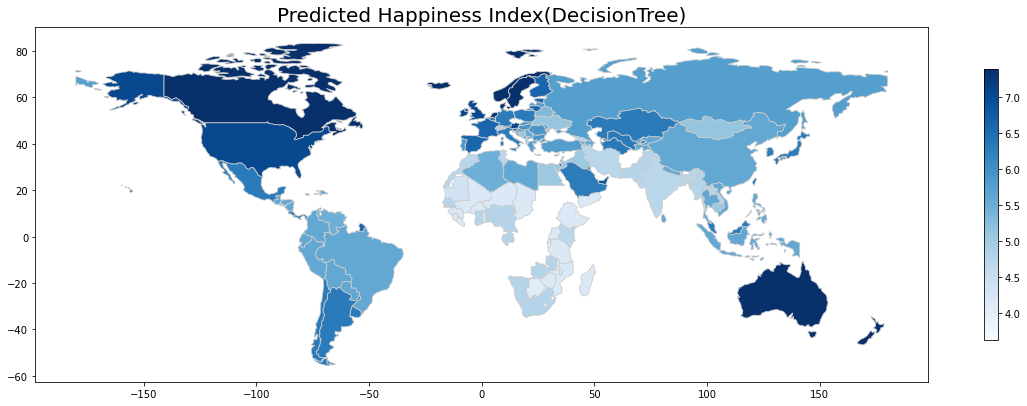

In [17]:
name = data_2021['Country name']
df_cols = ['pred_score','Country name']
pred = pd.Series(pred,name = 'pred score')

pred_data = pd.concat([name,pred],axis=1)
plot_on_worldmap(pred_data, 'pred score', 'Predicted Happiness Index(DecisionTree)')